## Computer Vision Coursework Project - CNN Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Computer Vision/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'CW_Dataset', 'Models', 'Personal_Video', 'test_function.ipynb']


The code in the following box was written with the help of the code present in lab 6 [1].

In [3]:

# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2024_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

In [4]:
# Make a folder to put the train and test sets into it
!mkdir -p CV2024_CW_Dataset

# Move files to CV2024_CW_Dataset folder
!mv test CV2024_CW_Dataset/
!mv train CV2024_CW_Dataset/

In [5]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


The great majority of the following code was taken from lab 9 [2].

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import copy

%matplotlib inline

In [7]:
data_dir = 'CV2024_CW_Dataset'
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

In [8]:
from PIL import Image

class CV2024Dataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(data_means, data_stds)
                ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(data_means, data_stds)
                ]),
            }

        if test:
            self.images =sorted([
                os.path.join(root_path, "test/images", i)
                for i in os.listdir(os.path.join(root_path, "test/images"))
                if i.endswith(".jpeg")
            ])
            self.labels = sorted([
                os.path.join(root_path, "test/labels", i)
                for i in os.listdir(os.path.join(root_path, "test/labels"))
                if i.endswith(".txt")
            ])
            self.transform = data_transforms['test']

        else:
            self.images = sorted([
                os.path.join(root_path, "train/images", i)
                for i in os.listdir(os.path.join(root_path, "train/images"))
                if i.endswith(".jpeg")
            ])
            self.labels = sorted([
                os.path.join(root_path, "train/labels", i)
                for i in os.listdir(os.path.join(root_path, "train/labels"))
                if i.endswith(".txt")
            ])
            self.transform = data_transforms['train']

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        img = self.transform(img)

        # Read label
        with open(self.labels[index], 'r') as f:
          label = int(f.read().strip())

        return img, label


    def __len__(self):
        return len(self.images)

In [9]:
BATCH_SIZE = 8
DATA_PATH = "CV2024_CW_Dataset"

train_dataset = CV2024Dataset(DATA_PATH)

train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

train_dataloader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
data_loaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

test_dataset = CV2024Dataset(DATA_PATH, test=True)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

The following code boxes were taken from lab 8 [3].

In [10]:
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}
class_names = ['0', '1', '2']

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print('----------------')

        # Each epoch has a training and testing phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in data_loaders[phase]:
                # move data to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} loss: {epoch_loss:.4f} accuracy: {epoch_acc:.4f}")

            # deep copy the model with best accuracy on test set
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best validation acc: {best_acc:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Before running our model, let's check some of the images - code taken from lab 9 [2].

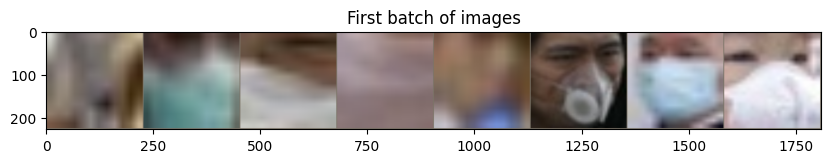

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
first_images, first_labels = next(iter(train_dataloader))

# Make a grid from batch
out_images = torchvision.utils.make_grid(first_images)

plt.figure(figsize=(10, 15))
imshow(out_images,'First batch of images')
plt.show()

Let's go ahead and define a function to visualize the model's predictions - lab 8 [3].

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(1, num_images, images_so_far)
                ax.axis('off')
                ax.set_title(f"Label: {class_names[labels[j]]}\nPrediction: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    plt.tight_layout()
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

The following code boxes are taken from lab 8 [3].

In [14]:
# Loading pre-trained model
model_ft = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 197MB/s]


In [15]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

In [16]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------------
train loss: 0.3829 accuracy: 0.8669
val loss: 0.3096 accuracy: 0.9038

Epoch 1/24
----------------
train loss: 0.2855 accuracy: 0.8972
val loss: 0.2603 accuracy: 0.9205

Epoch 2/24
----------------
train loss: 0.2747 accuracy: 0.9081
val loss: 0.1913 accuracy: 0.9372

Epoch 3/24
----------------
train loss: 0.2756 accuracy: 0.9061
val loss: 0.2423 accuracy: 0.9310

Epoch 4/24
----------------
train loss: 0.2167 accuracy: 0.9264
val loss: 0.2122 accuracy: 0.9310

Epoch 5/24
----------------
train loss: 0.2137 accuracy: 0.9228
val loss: 0.1959 accuracy: 0.9393

Epoch 6/24
----------------
train loss: 0.1962 accuracy: 0.9316
val loss: 0.2500 accuracy: 0.9414

Epoch 7/24
----------------
train loss: 0.1605 accuracy: 0.9452
val loss: 0.2242 accuracy: 0.9414

Epoch 8/24
----------------
train loss: 0.1692 accuracy: 0.9494
val loss: 0.2166 accuracy: 0.9414

Epoch 9/24
----------------
train loss: 0.1652 accuracy: 0.9473
val loss: 0.1979 accuracy: 0.9456

Epoch 10/2

Now that we've trained the model and have our best validation accuracy, we can go ahead and define a function to be able to test it.

In [18]:
def test_model(model, test_loader, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    running_corrects =0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")

    return all_labels, all_preds

In [19]:
# Test the model
labels, preds = test_model(model_ft, test_dataloader, criterion)

Test Loss: 0.0954
Test Accuracy: 0.9694


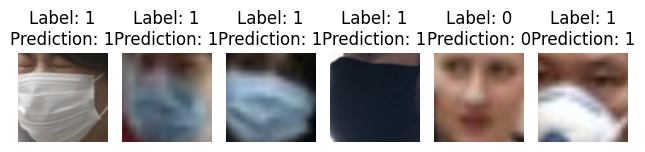

In [20]:
visualize_model(model_ft, num_images=6)

In [21]:
# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(labels, preds))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        51
           1       0.97      1.00      0.99       388
           2       0.79      0.79      0.79        19

    accuracy                           0.97       458
   macro avg       0.92      0.87      0.89       458
weighted avg       0.97      0.97      0.97       458



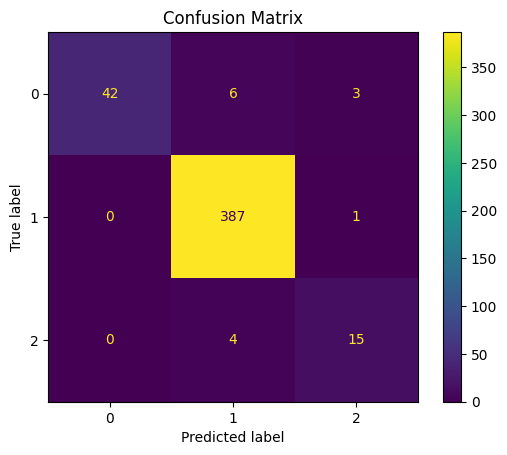

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  # <- Use your actual class names
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted', zero_division=0)
recall = recall_score(labels, preds, average='weighted')
f1 = f1_score(labels, preds, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9694
Precision: 0.9699
Recall:    0.9694
F1 Score:  0.9686


## References

[1] G. Tarroni, *Lab_06_Solved,* unpublished lab tutorial, Dept. of Science and Technology, City St. George's, University of London, 2025.

[2] G. Tarroni, *Lab_09,* unpublished lab tutorial, Dept. of Science and Technology, City St. George's, University of London, 2025.

[3] G. Tarroni, *Lab_08_Solved,* unpublished lab tutorial, Dept. of Science and Technology, City St. George's, University of London, 2025.

Let's save the best model.

In [26]:
modelPath = "/content/drive/My Drive/Computer Vision/CW_Folder_PG/Models/BEST_CNN.pth"
torch.save(model_ft.state_dict(), modelPath)